In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

In [2]:
from_date = datetime.datetime(2010, 6, 29) # 1277769600
today = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
csv_file = 'https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=' + from_date.strftime('%s') + '&period2=' + today.strftime('%s') + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = '../data/tsla_HistoricalData.csv'
max_age = datetime.timedelta(days=1)
if os.path.exists(local_file) or today - datetime.datetime.fromtimestamp(os.path.getmtime(local_file)) > max_age:
    print('Using local file')
else:
    print('Downloading file')
    import urllib.request
    urllib.request.urlretrieve(csv_file, local_file)
df = pd.read_csv(csv_file, encoding='cp1252', usecols=['Date', 'Adj Close'])

FileNotFoundError: [Errno 2] No such file or directory: '../data/tsla_HistoricalData.csv'

In [ ]:
df.rename(columns={'Price': 'Pre-split Price'}, inplace=True)
df.rename(columns={'Adj Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_values(by='Date', ascending=True, inplace=True)
df.head()

,Price
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [ ]:
# daily change in business working days 52 * 5 = 260 - 8 public holidays = 252
df['Change'] = df['Price'].pct_change(periods=252) * 100
df.tail()

,Price,Change
Date,,
2023-12-27,261.440002,112.293949
2023-12-28,253.179993,132.062326
2023-12-29,248.479996,120.459585
2024-01-02,248.419998,103.923820
2024-01-03,238.449997,93.578501


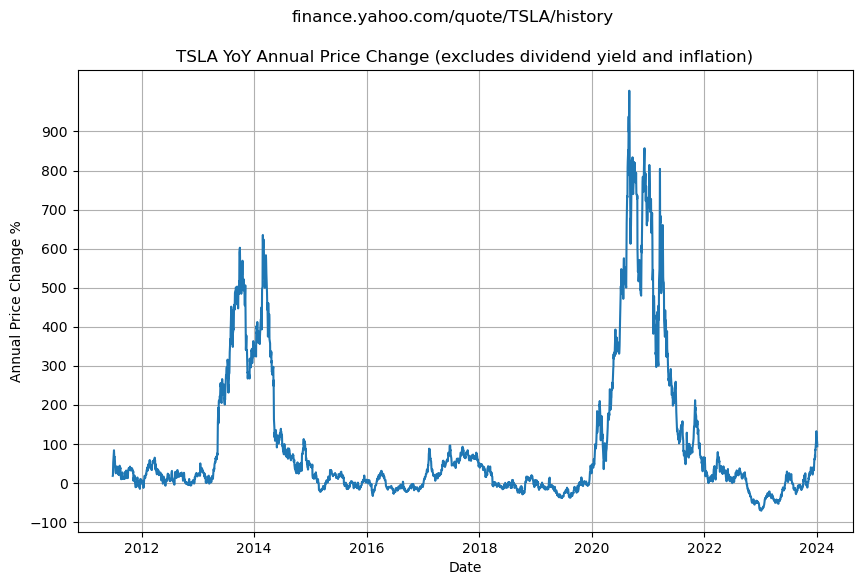

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Change'])
plt.xlabel('Date')
plt.ylabel('Annual Price Change %')
plt.suptitle('finance.yahoo.com/quote/TSLA/history')
plt.title('TSLA YoY Annual Price Change')
plt.grid(True)
plt.yticks(range(-100, 1000, 100))
plt.show()

In [ ]:
df['3_yr_rolling'] = df['Change'].rolling(window=252*3, min_periods=252).mean()
df.tail()

,Price,Change,3_yr_rolling
Date,,,
2023-12-27,261.440002,112.293949,90.177252
2023-12-28,253.179993,132.062326,89.468576
2023-12-29,248.479996,120.459585,88.740280
2024-01-02,248.419998,103.923820,87.947881
2024-01-03,238.449997,93.578501,87.105496


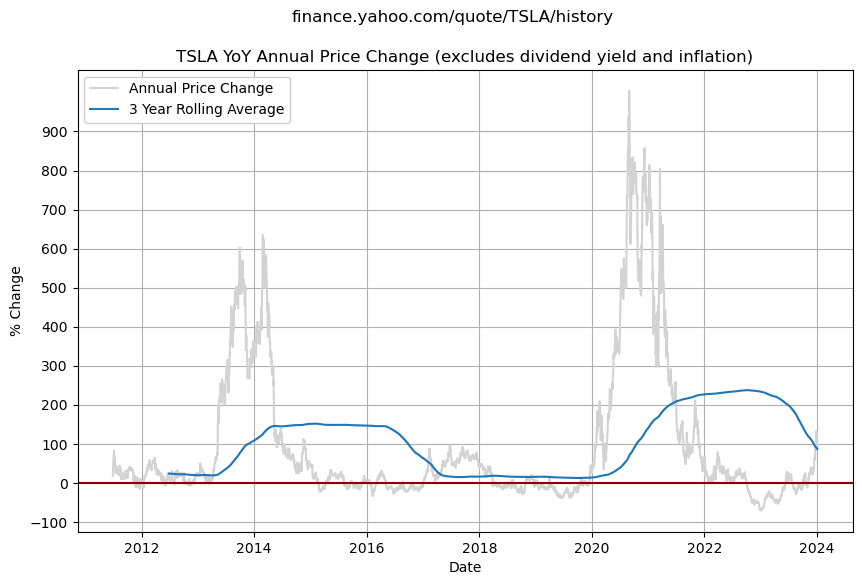

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Change'], label='Annual Price Change', color='lightgrey')
plt.plot(df.index, df['3_yr_rolling'], label='3 Year Rolling Average')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.suptitle('finance.yahoo.com/quote/TSLA/history')
plt.title('TSLA YoY Annual Price Change (excludes dividend yield and inflation)')
plt.yticks(range(-100, 1000, 100))
plt.grid(True)
plt.axhline(y=0, color='darkred')  # Add horizontal line at y=0
legend = plt.legend(loc='upper left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()

In [ ]:
# Given price targets data is manually collected it is easier to use a markdown table than csv file
csv_file = '../data/tsla_PriceTargets.md'
# Read markdown table as csv format with '|' as separator and skip the row of '----' separators
dfTargets = pd.read_csv('../data/tsla_PriceTargets.md', sep='|', skipinitialspace=True, skiprows=[1])
# Drop the first and last (empty) columns due to how the markdown table is imported
dfTargets = dfTargets.iloc[:, 1:-1]  
# Remove leading/trailing white spaces from column names
dfTargets.columns = dfTargets.columns.str.strip()
# Remove leading/trailing white spaces from data
dfTargets = dfTargets.applymap(lambda x: x.strip() if isinstance(x, str) else x)
dfTargets['Date'] = pd.to_datetime(dfTargets['TargetDate'],dayfirst=True)
dfTargets['ForecastDate'] = pd.to_datetime(dfTargets['ForecastDate'],dayfirst=True)
dfTargets.set_index('Date', inplace=True)
dfTargets = dfTargets.sort_values(by=['Source', 'TargetDate'])
#print(dfOther.columns)


In [ ]:
def adjust_price(row, date, multiplier):
    if row['ForecastDate'] < pd.to_datetime(date):
        row['Bear'] = (row['Bear'] / multiplier)
        row['Base'] = (row['Base'] / multiplier)
        row['Bull'] = (row['Bull'] / multiplier)
    return row

# 5-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2020-08-28', 5), axis=1)
# 3-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2022-08-25', 3), axis=1)


In [ ]:
# Gets mucky when there is multiple targets for the same forecase date
dfTargets = dfTargets.sort_values(['Source', 'ForecastDate', 'TargetDate'])

grouped = dfTargets.groupby(['Source'])
for name, group in grouped:
    extended_forecast = group.groupby(['ForecastDate'])

    # This technique will fail if there is gap in data, assumes the previous row is the previous year
    for extended_name, subgroup in extended_forecast: 
        subgroup['BaseChange'] = subgroup['Base'].pct_change() * 100 # change since previous row
        subgroup['BearChange'] = subgroup['Bear'].pct_change() * 100 # change since previous row

extended_forecast.head(20)

In [ ]:
#import matplotlib.pyplot as plt

colors = {}
colors['tsla']='#3f77e4'
colors['ark']={
    'bear': 'darkorange',
    'base': '#888888',
    'bull': 'orange',
}
colors['other']=[
    'mediumseagreen',#'#3CB371',
    'olivedrab',#'#6B8E23',
    'green',#'#008000',
    'darkgreen',#'#006400',
    'mediumseagreen',#'#3CB371',
    'darkseagreen',#'#8FBC8F',
    'limegreen',#'#32CD32',
    'seagreen',#'#2E8B57',
    'forestgreen',#'#228B22',
    'yellowgreen',#'#9ACD32',
    'darkolivegreen',#'#556B2F',
    'olive',#'#808000',

    'springgreen',#'#00FF7F',
    'mediumspringgreen',#'#00FA9A',

    # light green colors
    'lightgreen',#'#90EE90',
    'palegreen',#'#98FB98',

    # bright green colors
    'greenyellow',#'#ADFF2F',
    'lawngreen',#'#7CFC00',
    'lime',#'#00FF00',
]

/tmp/ipykernel_3839/2051860956.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rolling_forecast['BearChange'] = rolling_forecast['Bear'].pct_change() * 100 # change since previous row
/tmp/ipykernel_3839/2051860956.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rolling_forecast['BaseChange'] = rolling_forecast['Base'].pct_change() * 100 # change since previous row


InvestA uses mediumseagreen
RandyKirk uses olivedrab
SMR uses green


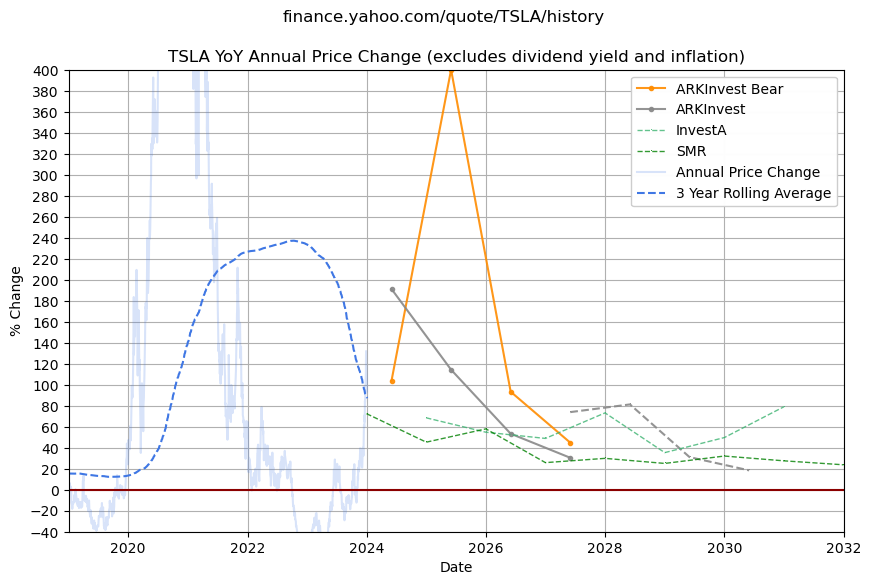

In [ ]:
# Extend the four year forecast to the end of the data
extendFourYear = True
# Show other forecasts (in addition to ARK)
showOther = True

if not showOther:
    dfTargets = dfTargets[dfTargets['Source'] == 'ARKInvest']

plt.figure(figsize=(10, 6))

grouped = dfTargets.groupby(['Source'])
for name, group in grouped:
    if name[0] == 'ARKInvest':
        line_color = colors['ark']
        line_alpha = 0.9
        line_width = 1.5
    else:
        rng_color = colors['other'].pop(0)
        colors['other'].append(rng_color)
        line_color = {
            'bear': rng_color,
            'base': rng_color,
            'bull': rng_color,
        }
        line_alpha = 0.8
        line_width = 1.0
        print(name[0]+ ' uses ' + rng_color)
            
    # Plot rolling ongoing forecast eg 4 year forecast updated each year
    rolling_forecast = group.drop_duplicates('ForecastDate')

    # Plot extended forecasts that have the same 'ForecastDate'
    extended_forecast = group.groupby(['ForecastDate'])

    for extended_name, subgroup in extended_forecast:
        if subgroup['Base'].notna().sum() > 1:
            if len(rolling_forecast) > 1:
                label_text = None # Hide label for extended forecasts if rolling forecast is also shown
            else:
                label_text = name[0]
            subgroup['BaseChange'] = subgroup['Base'].pct_change() * 100 # change since previous row
            plt.plot(subgroup.index, subgroup['BaseChange'], linestyle='dashed', marker=',', label=label_text, color=line_color['base'], alpha=line_alpha, linewidth=line_width)
        #if subgroup['Bear'].notna().sum() > 1:
        #    subgroup_bear = subgroup.dropna(subset=['BearChange'])
        #    if len(rolling_forecast) > 1:
        #        label_text = None # Hide label for extended forecasts if rolling forecast is also shown
        #    else:
        #        label_text = name[0]+' Bear'
        #    line_alpha = line_alpha * 0.8
        #    subgroup['BearChange'] = subgroup['Bear'].pct_change() * 100 # change since previous row
        #    plt.plot(subgroup_bear.index, subgroup_bear['BearChange'], linestyle='dashed', marker=',', label=label_text, color=line_color['bear'], alpha=line_alpha, linewidth=line_width)




    if len(rolling_forecast) > 1:
        if group['Bear'].notna().sum() > 1:
            rolling_forecast['BearChange'] = rolling_forecast['Bear'].pct_change() * 100 # change since previous row
            plt.plot(rolling_forecast.index, rolling_forecast['BearChange'], marker='.', label=name[0]+' Bear', color=line_color['bear'], alpha=line_alpha)
        if group['Base'].notna().sum() > 1:
            rolling_forecast['BaseChange'] = rolling_forecast['Base'].pct_change() * 100 # change since previous row
            plt.plot(rolling_forecast.index, rolling_forecast['BaseChange'], marker='.', label=name[0], color=line_color['base'], alpha=line_alpha)
        #if group['Bull'].notna().sum() > 1:
        #    rolling_forecast['BullChange'] = rolling_forecast['Bull'].pct_change() * 100 # change since previous row
        #    plt.plot(rolling_forecast.index, rolling_forecast['Bull'], marker='.', label=name[0]+' Bull', color=line_color['bull'], alpha=line_alpha)   




plt.plot(df.index, df['Change'], label='Annual Price Change', color='#3f77e4', alpha=0.2)
plt.plot(df.index, df['3_yr_rolling'], label='3 Year Rolling Average', linestyle='dashed', color='#3f77e4')
plt.xlabel('Date')
plt.ylabel('YoY % Change')
plt.suptitle('finance.yahoo.com/quote/TSLA/history')
plt.title('TSLA YoY Annual Price Change (excludes dividend yield and inflation)')
plt.yticks(range(-100, 1000, 20))

if extendFourYear:
    right_limit = pd.to_datetime('2032-01-01')
    top_limit = 400
else:
    right_limit = pd.to_datetime('2028-01-01')
    top_limit = 400
plt.ylim(bottom=-40, top=top_limit) 
plt.xlim(left=pd.to_datetime('2019-01-01'), right=right_limit)


plt.grid(True)
plt.axhline(y=0, color='darkred')  # Add horizontal line at y=0
legend = plt.legend() #loc='upper left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()